In [ ]:
# default_exp modeling.seq2seq.core


In [ ]:
# all_slow


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.seq2seq.core

> This module contains core custom models, loss functions, etc... for Seq2Seq based tasks (e.g., language modeling, summarization, translation, etc...)

In [ ]:
# export
import torch

from datasets import load_metric as hf_load_metric
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, RandomSplitter
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.all import *
from transformers import PreTrainedModel, logging

import nltk
from nltk.tokenize import sent_tokenize

nltk.download("wordnet", quiet=True)  # download punctuation rules

from blurr.utils import BLURR
from blurr.data.core import first_blurr_tfm
from blurr.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqTextBlock, Seq2SeqTextInput
from blurr.modeling.core import BaseModelWrapper, BaseModelCallback, PreCalculatedCrossEntropyLoss

logging.set_verbosity_error()


In [ ]:
# hide_input
import pdb

from datasets import load_dataset
from fastai.optimizer import Adam, OptimWrapper, params
from fastcore.test import *
from nbdev.showdoc import show_doc
from transformers import BartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.16.2


In [ ]:
# hide
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Mid-level API

### `blurr_seq2seq_splitter`

We add a custom param splitter to give us a bit more depth in applying discriminative learning rates for Seq2Seq tasks.

In [ ]:
# export
def blurr_seq2seq_splitter(
    # A Hugging Face model
    m: PreTrainedModel,
    # The name of the architecture you are working with (e.g., bart, fsmt, pegasus, etc...)
    arch: str,
):
    """Custom param splitter for summarization models"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m

    if arch in ["bart", "blenderbot", "blenderbot_small", "fsmt", "marian", "mbart", "pegasus"]:
        embeds_modules = [
            model.model.encoder.embed_positions,
            model.model.encoder.embed_tokens,
            model.model.decoder.embed_positions,
            model.model.decoder.embed_tokens,
        ]
        if arch != "fsmt":
            embeds_modules.insert(0, model.model.shared)

        embeds = nn.Sequential(*embeds_modules)
        groups = L(embeds, model.model.encoder, model.model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)

    if arch in ["led"]:
        embeds_modules = [
            model.led.encoder.embed_positions,
            model.led.encoder.embed_tokens,
            model.led.decoder.embed_positions,
            model.led.decoder.embed_tokens,
        ]

        embeds = nn.Sequential(*embeds_modules)
        groups = L(embeds, model.led.encoder, model.led.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)

    if arch in ["mt5", "t5"]:
        embeds = nn.Sequential(model.shared, model.encoder.embed_tokens, model.decoder.embed_tokens)

        groups = L(embeds, model.encoder, model.decoder)
        return groups.map(params).filter(lambda el: len(el) > 0)

    if arch in ["prophetnet", "xlm_prophetnet"]:
        embeds = nn.Sequential(
            model.prophetnet.word_embeddings,
            model.prophetnet.encoder.word_embeddings,
            model.prophetnet.encoder.position_embeddings,
            model.prophetnet.decoder.word_embeddings,
            model.prophetnet.decoder.position_embeddings,
            model.prophetnet.decoder.ngram_embeddings,
        )

        groups = L(embeds, model.prophetnet.encoder.layers, model.prophetnet.decoder.layers, model.lm_head)
        return groups.map(params).filter(lambda el: len(el) > 0)

    raise ValueError(f"seq2seq_splitter does not support this architecutre: {arch}")


In [ ]:
show_doc(blurr_seq2seq_splitter)


<h4 id="blurr_seq2seq_splitter" class="doc_header"><code>blurr_seq2seq_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>blurr_seq2seq_splitter</code>(**`m`**:`PreTrainedModel`, **`arch`**:`str`)

Custom param splitter for summarization models

||Type|Default|Details|
|---|---|---|---|
|**`m`**|`PreTrainedModel`||A Hugging Face model|
|**`arch`**|`str`||The name of the architecture you are working with (e.g., bart, fsmt, pegasus, etc...)|


### `Seq2SeqMetricsCallback`

BLURR provides a special callback for seq2seq models for calculating a variety of useful metrics that require decoding both given and predicted input_ids to be calculated.  The are:

- rouge (e.g., "rouge1", "rouge2", "rougeL", "rougeLsum")
- bert_score (e.g., "precision", "recall", "f1")
- bleu
- bleurt
- meteor
- sacrebleu

In [ ]:
# export
class Seq2SeqMetricsCallback(Callback):
    """A callback that adds seq2seq metrics"""

    def __init__(
        self,
        # A dictionary of seq2seq metrics we want to use. See below and the various task specific seq2seq docs
        # for examples of how to configure this per task
        custom_metrics: dict = None,
        # Calculation of these metrics requires text generation, which is expensive.  You can choose to calculate
        # these metrics on every 'epoch', 'other_epoch', or 'last_epoch' instead (default: 'epoch')
        calc_every: str = "epoch",
        # The token ID that should be ignored when calculating the loss
        ignore_token_id=CrossEntropyLossFlat().ignore_index,
        # Any keyword arguments to pass to the `hf_model.generate` method
        text_gen_kwargs: dict = {},
        # Keyword arguments to apply to `HF_Seq2SeqMetricsCallback`
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.order = Recorder.order - 1

        store_attr(self=self, names="custom_metrics, calc_every, ignore_token_id, text_gen_kwargs, kwargs")
        self.custom_metric_funcs, self.custom_metric_vals, self.do_calc = {}, {}, True

        if custom_metrics is not None:
            for metric_name, metric_info_dict in custom_metrics.items():
                # self.custom_metric_funcs (tuple): the function to compute the metric and what should be returned,
                # if the "compute_func" is not defined, we assume it is a Hugging Face metric
                if "compute_func" in metric_info_dict:
                    compute_func = metric_info_dict["compute_func"]
                else:
                    compute_func = hf_load_metric(metric_name).compute

                compute_kwargs = metric_info_dict["compute_kwargs"] if ("compute_kwargs" in metric_info_dict) else {}
                metric_returns = metric_info_dict["returns"]

                self.custom_metric_funcs[metric_name] = (partial(compute_func, **compute_kwargs), metric_returns)

                # self.custom_metric_vals (list): all the custom metrics to report as a "ValueMetric"
                if metric_name == "rouge":
                    self.custom_metric_vals.update({rouge_type: None for rouge_type in metric_returns})
                elif is_listy(metric_returns):
                    self.custom_metric_vals.update({f"{metric_name}_{ret_val}": None for ret_val in metric_returns})
                else:
                    self.custom_metric_vals.update({metric_name: None})

        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # grab the hf_tokenizer from the BatchTokenizeTransform (used for rouge metrics)
        tfm = first_blurr_tfm(self.learn.dls)
        self.hf_tokenizer = tfm.hf_tokenizer
        self.tok_kwargs = tfm.tok_kwargs

        # use before batch tfm's text_gen_kwargs if user doesn't pass in their own kwargs
        if len(self.text_gen_kwargs) == 0:
            self.text_gen_kwargs = tfm.text_gen_kwargs

        # add seq2seq generation specific metrics (rouge, bertscore, bleu, etc...) to learner metrics
        metric_keys = list(self.custom_metric_vals.keys())
        custom_metrics = L([ValueMetric(partial(self.metric_value, metric_key=k), k) for k in metric_keys])
        self.learn.metrics = self.learn.metrics + custom_metrics

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- epoch begin/after phases ---
    def before_epoch(self):
        current_epoch_n = self.epoch + 1
        if current_epoch_n == self.n_epoch:  # we always calc on last epoch
            self.do_calc = True
        elif self.calc_every == "epoch":
            self.do_calc = True
        elif self.calc_every == "other_epoch" and current_epoch_n % 2 == 0:
            self.do_calc = True
        else:
            self.do_calc = False

    # --- batch begin/after phases ---
    def after_batch(self):
        if self.training or self.learn.y is None or self.custom_metrics is None or not self.do_calc:
            return

        # grab predicted and reference ids for any metrics that need them
        input_ids, attention_mask = self.xb[0]["input_ids"], self.xb[0]["attention_mask"]
        gen_ids = self.learn.model.hf_model.generate(input_ids=input_ids, attention_mask=attention_mask, **self.text_gen_kwargs)

        self.generated_ids += gen_ids.tolist()
        self.refernce_ids += [seq[seq != self.ignore_token_id].tolist() for seq in self.yb[0]]

    # --- validation begin/after phases ---
    def before_validate(self):
        self.generated_ids, self.refernce_ids = [], []

    def after_validate(self):
        if self.learn.y is None or self.custom_metrics is None or not self.do_calc:
            return

        # fetch the generated prediction and reference tokens and texts
        gen_toks = [self.hf_tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True) for ids in self.generated_ids]
        ref_toks = [self.hf_tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True) for ids in self.refernce_ids]

        gen_texts = self.hf_tokenizer.batch_decode(self.generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        ref_texts = self.hf_tokenizer.batch_decode(self.refernce_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        # calculate any seq2seq metrics
        for metric_name, metric_info in self.custom_metric_funcs.items():
            compute_func, return_val = metric_info

            # some metrics work on tokens (bleu), some allow for multiple references (blue, sacrebleu), and most
            # work directly on the generated and reference texts; here blurr does the dirty work of getting your
            # preds/references formatted for the metric you are using
            if metric_name == "bleu":
                predictions, references = gen_toks, [[toks] for toks in ref_toks]
            elif metric_name == "sacrebleu":
                predictions, references = gen_texts, [[txt] for txt in ref_texts]
            elif metric_name == "rouge":
                predictions = ["\n".join(sent_tokenize(pred.strip())) for pred in gen_texts]
                references = ["\n".join(sent_tokenize(ref_text.strip())) for ref_text in ref_texts]
            else:
                predictions, references = gen_texts, ref_texts

            # calls the metrics "compute" function
            res = compute_func(predictions=predictions, references=references)

            # updates the custom_metric_vals with the metric's value
            if metric_name == "rouge":
                for rouge_key, scores in res.items():
                    self.custom_metric_vals[rouge_key] = scores.mid.fmeasure
            if metric_name == "bertscore":
                for score_key, score in res.items():
                    if f"{metric_name}_{score_key}" not in self.custom_metric_vals:
                        continue
                    self.custom_metric_vals[f"{metric_name}_{score_key}"] = np.array(score).mean().item()
            elif is_listy(return_val):
                for score_key, score in res.items():
                    if f"{metric_name}_{score_key}" not in self.custom_metric_vals:
                        continue
                    self.custom_metric_vals[f"{metric_name}_{score_key}"] = score
            else:
                self.custom_metric_vals[metric_name] = res[return_val]

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metric_vals[metric_key]


### Example

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1000]")
cnndm_df = pd.DataFrame(dataset)
cnndm_df.head(2)


Reusing dataset cnn_dailymail (/home/wgilliam/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)


('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=256, max_target_length=130)
blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("article"), get_y=ColReader("highlights"), splitter=RandomSplitter())


In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=2)


In [ ]:
b = dls.one_batch()


In [ ]:
len(b), b[0]["input_ids"].shape, b[1].shape


(2, torch.Size([2, 256]), torch.Size([2, 72]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)


,text,target
0,"<s> (CNN) -- When Ji Yeqing awakened, she was already in the recovery room. Chinese authorities had dragged her out of her home and down four flights of stairs, she said, restraining and beating her husband as he tried to come to her aid. They whisked her into a clinic, held her down on a bed and forced her to undergo an abortion. Her offense? Becoming pregnant with a second child, in violation of China's one-child policy. ""After the abortion, I felt empty, as if something was scooped out of me,"" Ji told a congressional panel in September. ""My husband and I had been so excited for our new baby. Now suddenly all that hope and joy and excitement disappeared.... I was very depressed and despondent. For a long time, whenever I thought about my lost child, I would cry."" As she lay unconscious, she said, an IUD to prevent future pregnancies was inserted. The issue of forced abortions -- and in some cases, forced sterilizations -- in China has seized the spotlight in recent days with news of escaped activist Chen Guangcheng. Chen, a blind, self-taught lawyer, rose to fame in the late 1990s because of his advocacy for what he calls victims</s>","China's one-child policy results in forced abortions and sterilizations, activists say.\nWomen tell of emotional and physical consequences from the procedures.\nActivist Chen Guangcheng works to advocate for victims of such practices."
1,"<s> Washington (CNN) -- New details emerged of what the White House knew about the Internal Revenue Service targeting of conservative groups, with spokesman Jay Carney disclosing Chief of Staff Denis McDonough was among the top officials made aware of the matter late last month. In a new timeline provided by Carney to reporters on Monday, General Counsel Kathryn Ruemmler learned on April 24 of a pending Treasury inspector general's report on how IRS staff used criteria targeting conservative groups in assessing eligibility for tax-exempt status. According to Carney, Ruemmler told McDonough as well as other Treasury officials about the pending report. It was the first time the White House acknowledged that McDonough was aware of the report before it became public in early May. IRS: By the numbers. In addition, Carney made clear that the information Ruemmler received on April 24 included details of improper acts by IRS officials. At the same time, Carney emphasized that the information was preliminary and could have changed before the inspector general released his final report on May 14. Carney insisted no one -- including Ruemmler and McDonough -- told President Barack Obama anything about the inspector general's pending report before media reports about it began appearing on May 10. ""We knew the subject of the investigation</s>",A Senate committee holds a hearing Tuesday on the IRS targeting.\nWhite House discloses new details of what it knew about the IRS targeting report.\nWhite House spokesman says President Obama wasn't told of the pending report.\nNEW: First lawsuit filed over IRS targeting.


#### Training

In [ ]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
    "bleu": {"returns": "bleu"},
    "meteor": {"returns": "meteor"},
    "sacrebleu": {"returns": "score"},
}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics, calc_every="other_epoch")]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.unfreeze()


[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wgilliam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wgilliam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape


(4, torch.Size([]), torch.Size([2, 59, 50264]))

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape


(4, torch.Size([]), torch.Size([2, 56, 50264]))

In [ ]:
print(len(learn.opt.param_groups))


3


SuggestedLRs(minimum=3.311311302240938e-05, steep=6.309573450380412e-07, valley=6.30957365501672e-05, slide=2.0892961401841603e-05)

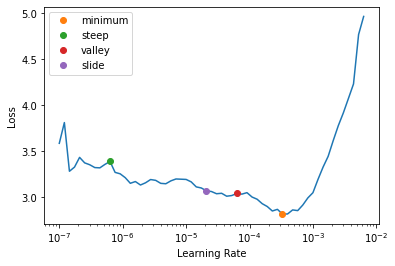

In [ ]:
# slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
# slow
learn.fit_one_cycle(1, lr_max=slice(9e-7, 9e-5), cbs=fit_cbs)


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,bleu,meteor,sacrebleu,time
0,1.940096,1.818711,0.400091,0.174751,0.276757,0.373374,0.881586,0.892300,0.886810,0.167536,0.361139,13.847786,03:47


#### Prediction

Below we'll add in additional functionality to take advantage of Hugging Face's `PreTrainedModel.generate` model, which can be used to easily implement beam search, top-k/nucleous sampling, etc... so that we get more human sounding results.

To make things even easier, for text generation tasks you can simply call the `Learn.blurr_generate` method, optionally passing in whatever text generation kwargs you wish, to accomplish the same as above.

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""


In [ ]:
b = dls.valid.one_batch()

tfm = first_blurr_tfm(dls)

b_hf_tokenizer = tfm.hf_tokenizer
b_ignore_token_id = tfm.ignore_token_id

test_input_ids = b[0]["input_ids"][0].unsqueeze(0).to(learn.model.hf_model.device)
test_trg_ids = b[1][0].unsqueeze(0).to(learn.model.hf_model.device)
test_trg_ids = [trg[trg != b_ignore_token_id] for trg in test_trg_ids]

gen_text = learn.model.hf_model.generate(test_input_ids, num_beams=4, max_length=130, min_length=30)

print("=== Target ===")
print(f"{b_hf_tokenizer.decode(test_trg_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)}\n")

print("=== Prediction ===")
print(b_hf_tokenizer.decode(gen_text[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))


=== Target ===
 NEW: With snow coming, authorities continue to hunt for the suspect near Big Bear Lake.
Police believe former cop Christopher Jordan Dorner shot three officers, killing one.
This was days after he allegedly killed two people, one a retired LAPD officer's daughter.
In an 11-page manifesto, Dorner promises "war" on police and their families.

=== Prediction ===
 Christopher Dorner is the focus of a massive manhunt.
Authorities believe he followed through on his threats.
Dorner is a former Navy lieutenant.
He was fired from his dream job as a police officer.


In [ ]:
outputs = learn.blurr_generate(test_article, num_return_sequences=3)
outputs


[{'generated_texts': [" A woman driving by unknowingly blocked the armed robbers' vehicles .\nShe was pulled from her vehicle, beat and robbed, and took off for the French border .\nThere were about 600 people in the casino at the time of the robbery .\nThe robbers spoke French and drove vehicles with French lRicense plates .\nSwiss authorities are working closely with French authorities .",
   " A woman driving by unknowingly blocked the armed robbers' vehicles .\nShe was pulled from her vehicle, beat and robbed .\nThe robbers made off with several hundred thousand Swiss francs .\nThere were about 600 people in the casino at the time of the robbery .\nNo serious injuries, although one guest was kicked in the head by one of the robbers .",
   " A woman driving by unknowingly blocked the armed robbers' vehicles .\nShe was pulled from her vehicle, beat and robbed, and took off for the French border .\nThere were about 600 people in the casino at the time of the robbery .\nThe robbers spo

#### Showing results

Much nicer!!! Now, we can update our @typedispatched `show_results` to use this new method.

In [ ]:
# export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `Seq2SeqTextInput` typed inputs
    x: Seq2SeqTextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    input_trunc_at=None,
    # Any truncation your want applied to your decoded targets
    target_trunc_at=None,
    # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
    text_gen_kwargs={},
    # Any other keyword arguments you want applied to `show_results`
    **kwargs
):
    tfm = first_blurr_tfm(learner.dls)
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id

    if len(text_gen_kwargs) == 0:
        text_gen_kwargs = tfm.text_gen_kwargs

    gen_text_txts = learner.blurr_generate(x, **text_gen_kwargs)
    res = L(
        [
            (
                hf_tokenizer.decode(s[0], skip_special_tokens=True)[:input_trunc_at],
                hf_tokenizer.decode(s[1][s[1] != ignore_token_id], skip_special_tokens=True)[:target_trunc_at],
                gen_txt["generated_texts"][:target_trunc_at],
            )
            for s, gen_txt in zip(samples, gen_text_txts)
        ]
    )

    display_df(pd.DataFrame(res, columns=["text", "target", "prediction"])[:max_n])
    return ctxs


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)


,text,target,prediction
0,"Los Angeles (CNN) -- A former Los Angeles cop with military training vowed war against other men in blue Thursday, leaving one officer dead days after he allegedly killed two other people to begin a wave of retribution for being fired, police said. The focus of the intensive, expansive manhunt is Christopher Jordan Dorner, a 270-pound former Navy lieutenant who has professed his venom against LAPD officers he claimed ruined his life by forcing him out of his dream job. Dorner blames one retired","NEW: With snow coming, authorities continue to hunt for the suspect near Big Bear Lake.\nPolice believe former cop Christopher Jordan Dorner shot three officers, killing one.\nThis was days after he allegedly killed two people, one a retired LAPD offi","[ Christopher Dorner is the focus of a massive manhunt .\nAuthorities believe he followed through on his threats .\nDorner is a former Navy lieutenant .\nHe was fired from his dream job as a police officer .\nPolice believe he shot a Riverside, California, police officer and two others ., Santi Cazorla accused of diving after Arsenal's match-turning penalty kick .\nCazorla's theatrical actions earned the Gunners a 1-0 win over West Brom in the English Premier League .\nDiving has long been a thorn in football's side, with fans often outraged by what they see as sporting fraud .\nPiers Morgan and former World Anti-Diving champion says he is ""ashamed to see an Arsenal player cheat so badly""]"


### Inference

In [ ]:
export_fname = "summarize_export"


In [ ]:
learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_generate(test_article)


[{'generated_texts': " A woman driving by unknowingly blocked the armed robbers' vehicles .\nShe was pulled from her vehicle, beat and robbed, and took off for the French border .\nThere were about 600 people in the casino at the time of the robbery .\nThe robbers spoke French and drove vehicles with French lRicense plates .\nSwiss authorities are working closely with French authorities ."}]

## Summary

This module includes the fundamental bits to all Seq2Seq transformers training and inference.

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
